In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class SegmentationDataset:
    def __init__(self, image_dir, mask_dir, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.images = os.listdir(image_dir)

    def load_image(self, file_path):
        img = load_img(file_path, target_size=self.img_size)
        img = img_to_array(img) / 255.0
        return img

    def load_mask(self, file_path):
        mask = load_img(file_path, target_size=self.img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        mask = tf.where(mask > 0.1, 1, 0)  # Binarize the mask
        mask = tf.squeeze(mask, axis=-1)  # Remove the last dimension
        mask = tf.one_hot(tf.cast(mask, tf.int32), depth=2)  # One-hot encode the mask with 2 classes
        return mask

    def __iter__(self):
        for img_name in self.images:
            img_path = os.path.join(self.image_dir, img_name)
            mask_name = img_name.replace(".jpg", ".png")  # Example: "image1.jpg" -> "image1_mask.png"
            mask_path = os.path.join(self.mask_dir, mask_name)
            img = self.load_image(img_path)
            mask = self.load_mask(mask_path)
            yield img, mask


# Set directories
image_dir = "./dataset/train/images/"
mask_dir = "./dataset/train/masks/"

# Create the dataset
dataset = SegmentationDataset(image_dir=image_dir, mask_dir=mask_dir)

# Convert to tf.data.Dataset
tf_dataset = tf.data.Dataset.from_generator(
    lambda: iter(dataset),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32)
    )
).batch(8).shuffle(100)

# Check the shapes of the dataset samples
for img_batch, mask_batch in tf_dataset.take(1):
    print(f"Image batch shape: {img_batch.shape}")
    print(f"Mask batch shape: {mask_batch.shape}")
    

Image batch shape: (8, 256, 256, 3)
Mask batch shape: (8, 256, 256, 2)


In [ ]:
# import matplotlib.pyplot as plt

# # Visualize a few image-mask pairs from the dataset
# for img_batch, mask_batch in tf_dataset.take(3):  # Display 3 pairs
#     for i in range(len(img_batch)):
#         img = img_batch[i]  # Get the ith image from the batch
#         mask = mask_batch[i]  # Get the ith mask from the batch

#         # Convert one-hot encoded mask back to the original mask for visualization
#         mask = tf.argmax(mask, axis=-1)  # Get the class with the highest probability

#         # Plot the image and its associated mask
#         plt.figure(figsize=(10, 5))

#         plt.subplot(1, 2, 1)
#         plt.imshow(img)
#         plt.title('Image')

#         plt.subplot(1, 2, 2)
#         plt.imshow(mask, cmap='gray')
#         plt.title('Mask')

#         plt.show()


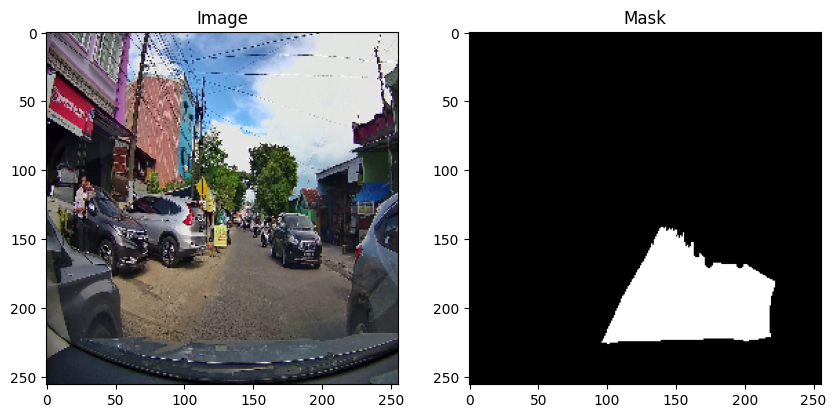

In [5]:
import matplotlib.pyplot as plt

# Get a batch of images and masks from the dataset
for img_batch, mask_batch in tf_dataset.take(1):
    img = img_batch[0]  # Take the first image in the batch
    mask = mask_batch[0]  # Take the first mask in the batch

    # Convert one-hot encoded mask back to the original mask for visualization
    mask = tf.argmax(mask, axis=-1)  # Get the class with the highest probability

    # Plot the image and mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Contracting path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder: Expansive path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Example usage
input_shape = (256, 256, 3)  # Change according to your input dimensions
num_classes = 2  # Number of classes in your segmentation task
model = unet_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [3]:
# Assuming dataset is your tf.data.Dataset object from before
model.fit(tf_dataset, epochs=5)

Epoch 1/5
38/38 [==============================] - 673s 17s/step - loss: 0.4761 - accuracy: 0.8040
Epoch 2/5
38/38 [==============================] - 659s 17s/step - loss: 0.2997 - accuracy: 0.8349
Epoch 3/5
38/38 [==============================] - 644s 16s/step - loss: 0.2574 - accuracy: 0.8970
Epoch 4/5
38/38 [==============================] - 650s 17s/step - loss: 0.2399 - accuracy: 0.8976
Epoch 5/5
38/38 [==============================] - 675s 17s/step - loss: 0.2285 - accuracy: 0.9043


In [4]:
model.save("unet_imgseg.h5")
model.save("unet_imgseg.keras")

C:\Users\karan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# Set directories
image_dir = "./dataset/valid/images/"
mask_dir = "./dataset/valid/masks/"

# Create the dataset
test_dataset = SegmentationDataset(image_dir=image_dir, mask_dir=mask_dir)

# Convert to tf.data.Dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: iter(dataset),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32)
    ) 
).batch(8).shuffle(100)

model.evaluate(test_dataset)

38/38 [==============================] - 148s 3s/step - loss: 0.2731 - accuracy: 0.8626


[0.2730658948421478, 0.8626378178596497]

1/1 [==============================] - 4s 4s/step


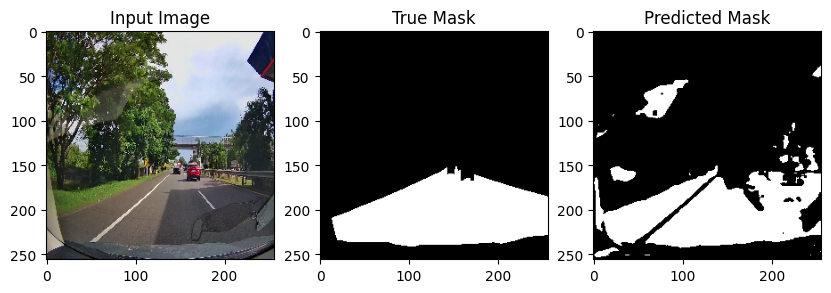

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images from the test dataset
for images, masks in test_dataset.take(1):
    predictions = model.predict(images)
    
    # Visualize the first image, its true mask, and the predicted mask
    plt.figure(figsize=(10, 10))
    
    # Input Image
    plt.subplot(1, 3, 1)
    plt.imshow(images[0])
    plt.title('Input Image')
    
    # True Mask (combined classes)
    true_mask_combined = np.argmax(masks[0].numpy(), axis=-1)
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_combined, cmap='gray')
    plt.title('True Mask')
    
    # Predicted Mask (combined classes)
    predicted_mask_combined = np.argmax(predictions[0], axis=-1)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_combined, cmap='gray')
    plt.title('Predicted Mask')
    
    plt.show()
